<a href="https://colab.research.google.com/github/saadam1n/CS4803-EML/blob/main/lab0/lab0_task3_Saad_Amin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pleas read:

before your start running this jupyter notebook, please click Edit > Notebook Settings and choose any of the available GPUs.

## 0. Import Python Packages

Install thop if not install already:

In [1]:
%pip install thop

Import all packages

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: you may import more packages below:
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import tqdm

import matplotlib.pyplot as plt

from torch.profiler import profile, ProfilerActivity, record_function
import torch.cuda.profiler as profiler

from thop import profile

## 1. Define your first network

In [3]:
# ResNet Block
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.silu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x)
        out = F.silu(out)
        return out

# MobileNetV2 block
class MobileNetV2Block(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(MobileNetV2Block, self).__init__()

        expansion_ratio = 4
        mid_planes = planes * expansion_ratio

        self.net = nn.Sequential(
            nn.Conv2d(in_planes, mid_planes, kernel_size=1, bias=False),
            nn.GELU(),
            nn.Conv2d(mid_planes, mid_planes, groups=mid_planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.GELU(),
            nn.Conv2d(mid_planes, planes, kernel_size=1, bias=False),
            nn.BatchNorm2d(planes)
        )


        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.net(x) + self.shortcut(x)
        return out

# https://arxiv.org/abs/2111.11418
class PoolFormerBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(PoolFormerBlock, self).__init__()

        self.pooler = nn.Sequential(
            nn.BatchNorm2d(in_planes),
            nn.MaxPool2d(kernel_size=3, stride=stride, padding=1)
        )

        self.ffn = nn.Sequential(
            nn.BatchNorm2d(in_planes),
            nn.Conv2d(in_planes, planes * 2, kernel_size=1, stride=1, bias=False),
            nn.SiLU(),
            nn.Conv2d(planes * 2, planes, kernel_size=1, stride=1, bias=False)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.BatchNorm2d(in_planes),
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, bias=False),
            )

    def forward(self, x):
        out = self.pooler(x) + x
        out = self.ffn(out) + self.shortcut(out)

        return out


# ResNet Model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # we utilize lazy in places to make it compatible with both CIFAR and MNIST

        self.conv1 = nn.LazyConv2d(64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.LazyLinear(num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

## 2. Implement training loop and test function

In [4]:
# I put in quite a bit of extra stuff to profile/optimizing training
# since I have an interview coming where I need to do that

def train(model, device, train_loader, optimizer, scheduler, epoch):
    model.train()

    # Compile for training
    model.compile(mode="reduce-overhead")

    running_loss = 0.0
    correct = 0
    total = 0
    loss_curve = []

    scaler = torch.amp.GradScaler("cuda")

    print_acc = False

    for epoch in tqdm.tqdm(range(epoch)):
      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)

          optimizer.zero_grad()

          with torch.autocast(device_type="cuda", dtype=torch.float16):
              output = model(data)
              loss = F.cross_entropy(output, target)

          scaler.scale(loss).backward()

          scaler.step(optimizer)
          scaler.update()

          running_loss += loss.item()

          if batch_idx % 100 == 0:
              loss_curve.append(loss.item())

              if print_acc:
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()

                print(f'Batch {batch_idx}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

      scheduler.step()



    return loss_curve

def test(model, device, test_loader):
    # TODO: finish this function, you are required to:
    # 1. print the loss and classification accuracy on the test set
    with torch.no_grad():
      model.eval()

      # This should force recompilation from training... I think
      model.compile(mode="reduce-overhead")

      running_loss = 0.0

      correct = 0
      total = 0

      total_latency = 0.0
      macs = 0

      for batch_idx, (data, target) in enumerate(test_loader):
          data, target = data.to(device), target.to(device)




          start = torch.cuda.Event(enable_timing=True)
          end = torch.cuda.Event(enable_timing=True)

          with torch.autocast(device_type="cuda", dtype=torch.float16):
            # torch.compile warmup before collecting timing data
            if batch_idx == 0:
              print("Warming up for torch.compile()...")
              for _ in range(3):
                  _ = model(data)

            start.record()
            output = model(data)
            end.record()

            loss = F.cross_entropy(output, target)

            if batch_idx == 0:
              # get a batch size of 1
              macs, params = profile(model, inputs=(data[:1], ))

          _, predicted = output.max(1)
          total += target.size(0)
          correct += predicted.eq(target).sum().item()

          running_loss += loss.item()

          # Measure latency
          torch.cuda.synchronize()
          total_latency += start.elapsed_time(end)

      print(f'Loss: {running_loss / len(test_loader):.4f}, Acc: {100.*correct/total:.2f}%, Latency: {total_latency / len(test_loader):.2f}ms, MACs: {macs / 1000000:.1f}M')


## 3. Dataset loading


In [5]:
# TODO: finish the code here, you are required to:
# 1. load the training and testing split of the MNIST dataset

load_mnist = False

if load_mnist:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(
        root="./data",
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = datasets.MNIST(
        root="./data",
        train=False,
        download=True,
        transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
else:
    # Data transforms
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # Dataset and DataLoader
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                 download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                download=True, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=384, shuffle=True, pin_memory=True)

    # assume that 8 is what we would have in a real inference scenario
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=True)




## 4. Put Everything Together

Data collected using `torch.compile(mode="default")` on a A100 system:

Regular ResNet:
- MNIST: Loss: 0.0178, Acc: 99.54%, Latency: 2.14ms, MACs: 457.7M
- CIFAR: Loss: 0.4036, Acc: 87.25%, Latency: 1.97ms, MACs: 557.9M

MobileNetV2:
- MNIST: Loss: 0.0181, Acc: 99.54%, Latency: 2.86ms, MACs: 269.7M
- CIFAR: Loss: 0.3543, Acc: 88.74%, Latency: 2.36ms, MACs: 337.2M

Given that we are seing negliglbe latency difference with reducing MACs, there are two possible bottlenecks:
- We are kernel launch bound. This is a very likely factor since we are performing computations on very small tensors and batch sizes. We might be able to solve this with `torch.compile("reduce-overhead")` which will create CUDA graphs to launch kernels sequentially from the GPU instead of waiting for the CPU to issue new kernel launch operations.
- We are memory bound. This is also a likely possibility since reducing MACs doesn't appear to affect latency, albiet less likely since kernel launch overhead is probably the biggest factor here. Given this limitation, we might want to come up with architectures that increase arithmetic intensity. ViTs would fit this requirement, but that would be cheating (we would be going with a completely different architecture). Another possibility is to increase the number of pointwise and fully connected convolutions, but the original ResNet does that already.

When we utilize `reduce-overhead` (all data besides latency and MNIST omitted):

Regular ResNet:
- CIFAR: Latency: 0.71ms

MobileNetV2:
- CIFAR: Latency: 0.77ms

That's surprising. Let's rerun on the the A100s provided by the AI makerspace, and let's take a look at the Nsys profiling report: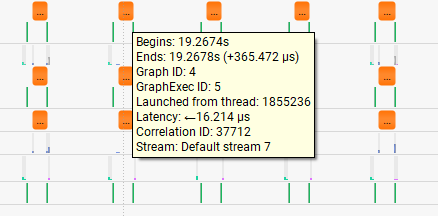

As you can see, the graph takes way less time (in the order of ~350 us), but there is a massive gap where our GPU is doing nothing. This is because we are now data-loading bound, despite the fact we are pinning memory. In a real inference scenario, we would be screwed, as batches don't come in that fast. Let's increase batch size up to 128 and see what happens.

ResNet:
- Latency: 11.33ms
- Latency: 86.50ms when Nsys collects data

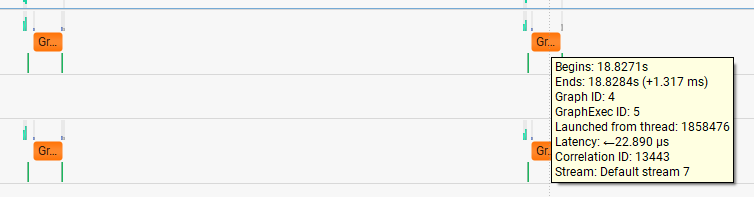

MobileNet:
- Latency: 32.13ms
- Latency: 100.25ms when Nsys collects data

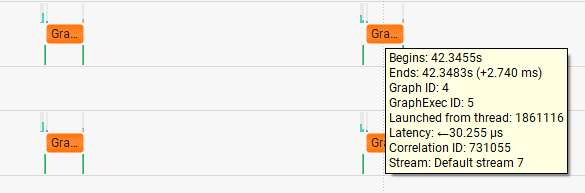

So according to this data, we can draw a few conclusions:
- Even with a larger batch size, we are massively bound by data loading.
- ResNet is actually faster than MobileNetV2. I think this is due to two factors:
  - MobileNetV2 has a more complex structure and thus probably wont be as compatible with `torch.compile`
  - MobileNetV2 also has more sequential operations. Namely, it has a very memory-bound depthwise kernel in between two pointwise kernels, and during that time the GPU is significantly underutilized.

In [6]:
# TODO: finish the code here, you are required to:
# 1. launch model training: recommended hyperparameter: batch size = 64, learning rate = 1.0, adam optimizer
# 2. visualize the training loss curve using matplotlib or any other libraries

latency_test_only = True

device = torch.device("cuda")

model = ResNet18()
model.to(device)


if not latency_test_only:
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

    losses = train(model, device, train_loader, optimizer, scheduler, 16)

    steps = [i * 100 for i in range(len(losses))]

    plt.figure(figsize=(8, 5))
    plt.plot(steps, losses, marker='o', label="Training Loss")

    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# run test
test(model, device, test_loader)

Warming up for torch.compile()...
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


skipping cudagraphs due to skipping cudagraphs due to cpu device (arg2_1). Found from : 
   File "/tmp/ipython-input-1519489046.py", line 109, in forward
    out = F.relu(self.bn1(self.conv1(x)))
  File "/usr/local/lib/python3.12/dist-packages/thop/vision/basic_hooks.py", line 28, in count_convNd
    m.total_ops += calculate_conv2d_flops(



Loss: 2.3026, Acc: 10.00%, Latency: 0.71ms, MACs: 557.9M
